# Customizing the Grain Size Distribution

This notebook illustrates how to use the provided cross section .fits files to compute the extinction, emission, and polarization from dust with arbitrary size distributions. The files needed to run this notebook are available here: https://doi.org/10.7910/DVN/PEXRD0.

Please cite [Hensley & Draine 2022](https://arxiv.org/abs/2208.12365) if using these data and/or code.

In [1]:
import numpy as np
from astropy.io import fits
from astropy import units as u

import matplotlib
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt

Read in the cross section files

In [2]:
hdul_ad = fits.open('astrodust_csecs.fits')
hdul_ad.info()
print('')
hdul_cion = fits.open('cion_csecs.fits')
hdul_cion.info()
hdul_cneu = fits.open('cneu_csecs.fits')
print('')
hdul_cneu.info()

Filename: astrodust_csecs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1  EFFECTIVE RADIUS    1 ImageHDU         8   (167,)   float64   
  2  WAVELENGTH    1 ImageHDU         8   (1000,)   float64   
  3  LOG10 U       1 ImageHDU         8   (91,)   float64   
  4  C_ABS         1 ImageHDU         9   (167, 1000)   float64   
  5  C_SCA         1 ImageHDU         9   (167, 1000)   float64   
  6  C_EXT         1 ImageHDU         9   (167, 1000)   float64   
  7  C_ABS^POL     1 ImageHDU         9   (167, 1000)   float64   
  8  C_EXT^POL     1 ImageHDU         9   (167, 1000)   float64   
  9  C_ABS*NUBNU(T)    1 ImageHDU        10   (167, 91, 1000)   float64   
 10  C_ABS^POL*NUBNU(T)    1 ImageHDU        10   (167, 91, 1000)   float64   

Filename: cion_csecs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  EFFECTIVE RADIUS    1 ImageHDU

First, we implement the parametric size distribution functions from Hensley & Draine 2022, including $f_{\rm ion}$ and $f_{\rm align}$. The size distribution functions for composition $i$ return $(1/n_{\rm H})dn_i/da$ (see Equations 18 and 25).

In [3]:
# PAHs/graphite ("car"bonaceous grains)
def size_car(a01, a02, sigma1, sigma2, amin, B1, B2, rad):    
    car1 = (B1/rad)*np.exp(-0.5*(np.log(rad/a01)/sigma1)**2)
    car2 = (B2/rad)*np.exp(-0.5*(np.log(rad/a02)/sigma2)**2)
    
    dnda = car1 + car2
    dnda[rad < amin] = 0.
    return dnda

# Astrodust
def size_Ad(Ad0, Ad1, Ad2, Ad3, Ad4, Ad5, a0, BAd, sigma, amin, rad):
    xrad = np.log(rad.to(u.AA).value)
    
    Ad_log = (BAd/rad)*np.exp(-0.5*(np.log(rad/a0)/sigma)**2)
    Ad_poly = (Ad0/rad)*np.exp(Ad1*xrad + Ad2*xrad**2 + 
                               Ad3*xrad**3 + Ad4*xrad**4 + 
                               Ad5*xrad**5)
    
    dnda = Ad_log + Ad_poly
    dnda[rad < amin] = 0.
    return dnda

# PAH ionization
def f_ion_func(a_h, rad):
    fion = 1. - 1./(1. + rad/a_h)
    return fion

# Alignment
def f_align_func(a_align, alpha_align, f_max, rad):
    return f_max/(1.+(a_align/rad)**alpha_align)

Next, we extract the radius information from the fits file. Note that the radius grid is the same for all grain compositions, so we need to read it in once only. In this notebook, we'll use astropy.units to prevent errors changing between cm, $\mu$m, and $\unicode[serif]{xC5}$.

In [4]:
rad = hdul_ad[1].data*u.um

We'll first use the default model parameters from Hensley & Draine 2022 (Table 1).

In [5]:
B1 = 7.52e-7
B2 = 8.09e-10
BAd = 3.31e-10
a0_Ad = 63.8*u.AA
sigma_Ad = 0.353
A0 = 2.97e-5
A1 = -3.40
A2 = -0.807
A3 = 0.157
A4 = 7.96e-3
A5 = -1.68e-3
a_align = 0.0749*u.um
alpha_align = 1.80
f_max = 1.00

There are a few additional parameters of the PAH size distribution defined in Section 3.2:

In [6]:
amin_PAH = 4.0*u.AA
a0_1 = 4.0*u.AA
a0_2 = 30*u.AA
sigma1_PAH = 0.40
sigma2_PAH = 0.40

Finally, the mininum grain size for astrodust is defined in Section 3.1:

In [7]:
amin_Ad = 4.5*u.AA

Now we can compute the $\left(1/n_{\rm H}\right)dn/da$.

In [8]:
dnda_Ad = size_Ad(A0, A1, A2, A3, A4, A5, a0_Ad, BAd, sigma_Ad, amin_Ad, rad)
dnda_PAH = size_car(a0_1, a0_2, sigma1_PAH, sigma2_PAH, amin_PAH, B1, B2, rad)

With a little bit of manipulation, we can reproduce the size distributions shown in Figure 1 of Hensley & Draine 2022. Note that $d\ln a = da/a$.

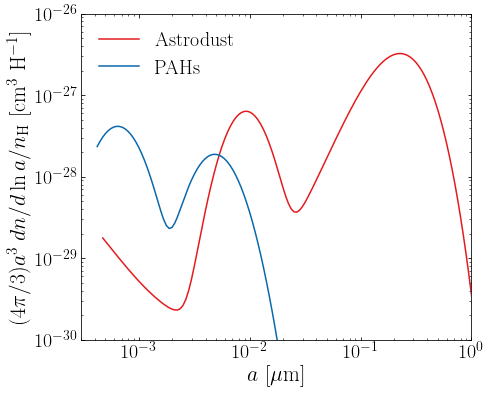

In [9]:
fig, ax = plt.subplots(1,1,figsize=(7., 6.))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$a\ [\mu{\rm m}]$',fontsize=22)
ax.set_ylabel(r'$(4\pi/3)a^3\ dn/d\ln a/n_{\rm H}\ [{\rm cm}^3\ \rm{H}^{-1}]$',fontsize=22)
ax.tick_params(axis='both', which='both', labelsize=20,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')
ax.axis([3.e-4, 1., 1.e-30, 1.e-26])

idx = np.where(dnda_Ad > 0.)
ax.plot(rad[idx].to(u.um),(dnda_Ad[idx]*np.pi*(4./3.)*rad[idx]**4).to(u.cm**3),color='#e41a1c',
           linestyle='-', label=r'${\rm Astrodust}$')
idx = np.where(dnda_PAH > 0.)
ax.plot(rad[idx].to(u.um),(dnda_PAH[idx]*np.pi*(4./3.)*rad[idx]**4).to(u.cm**3),color='#0868ac',
           linestyle='-', label=r'${\rm PAHs}$')
ax.legend(loc='upper left', frameon=False, prop={'size': 20});

For subsequent calculations, it is convenient to compute $(1/n_{\rm H}) dn_i$, i.e., the number of grains per H atom in each size bin. This is simply $(1/n_{\rm H})(dn/da)da$. The $(1/n_{\rm H}) dn_i$ are the values provided in the available size distribution files. Note that the radii are logspaced with with $d\ln a = 0.0576$.

In [10]:
dlna = np.log(rad[20]/rad[0])/20.
dn_Ad = dnda_Ad*rad*dlna
dn_PAH = dnda_PAH*rad*dlna

We'll need to distinguish between neutral and ionized PAHs, so let's compute $f_{\rm ion}$.

In [11]:
a_h = 10*u.AA # Standard ionization (Equation 20)
f_ion = f_ion_func(a_h, rad)

Finally, we're ready to use the cross sections. Let's start with extinction.

In [12]:
cext_Ad = hdul_ad[6].data*u.cm**2
cext_cion = hdul_cion[6].data*u.cm**2
cext_cneu = hdul_cneu[6].data*u.cm**2
cext_PAH = f_ion*cext_cion + (1.-f_ion)*cext_cneu

To compute the total extinction, we need simply to integrate $C^{\rm ext}$ over the size distribution (Equation 4). The "cext" variables are 2D arrays of size and wavelength, so we collapse the size dimension with the sum.

In [13]:
tau_Ad = np.sum(cext_Ad*dn_Ad, axis=1)
tau_PAH = np.sum(cext_PAH*dn_PAH, axis=1)

The wavelength vector is provided in HDU 2 and is the same for all compositions.

In [14]:
wav = hdul_ad[2].data*u.um

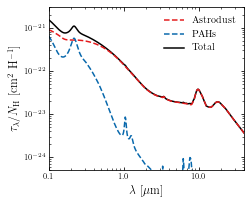

In [15]:
fig, ax = plt.subplots(1,1,figsize=(3.5, 3.))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda\ [\mu{\rm m}]$', fontsize=12)
ax.set_ylabel(r'$\tau_\lambda/N_{\rm H}\ [{\rm cm}^{2}\ {\rm H}^{-1}]$',
                 fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.axis([0.1, 40.,  5.e-25, 3.e-21])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(axis='both', which='both', labelsize=8,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')

ax.plot(wav.to(u.um), tau_Ad.to(u.cm**2), linestyle='--', color='#e41a1c', label=r'${\rm Astrodust}$')
ax.plot(wav.to(u.um), tau_PAH.to(u.cm**2), linestyle='--', color='#0868ac', label=r'${\rm PAHs}$')
ax.plot(wav.to(u.um), (tau_Ad+tau_PAH).to(u.cm**2), linestyle='-', color='k', label=r'${\rm Total}$', zorder=0)
ax.legend(loc='upper right', frameon=False, prop={'size': 10});

To compute polarized extinction, we first need the alignment function and the polarization cross sections for astrodust.

In [16]:
f_Ad = f_align_func(a_align, alpha_align, f_max, rad)
cextpol_Ad = hdul_ad[8].data*u.cm**2

Now it is just a matter of summing over the size distribution (Equation 6).

In [17]:
extpol_Ad = np.sum(cextpol_Ad*f_Ad*dn_Ad, axis=1)

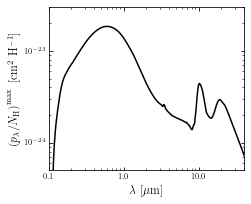

In [18]:
fig, ax = plt.subplots(1,1,figsize=(3.5, 3.))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda\ [\mu{\rm m}]$', fontsize=12)
ax.set_ylabel(r'$\left(p_\lambda/N_{\rm H}\right)^{\rm max}\ [{\rm cm}^{2}\ {\rm H}^{-1}]$',
                 fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.axis([0.1, 40.,  5.e-25, 3.e-23])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(axis='both', which='both', labelsize=8,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')

ax.plot(wav.to(u.um), extpol_Ad.to(u.cm**2), linestyle='-', color='k');

Computing emission requires knowledge of the intensity of the radiation heating the dust, which we parameterize with $\log_{10} U$. For each value of $U$, we compute the distribution of grain temperatures for each grain size and composition. The cross section fits files provide $\int dT \left(dP/dT\right) C^{\rm abs}\left(\lambda, a\right) \nu B_\nu\left(T\right)$, which is needed to compute the emission (Equation 8).

In [19]:
cabsBnu_Ad = hdul_ad[9].data*u.erg/u.s
cabsBnu_cion = hdul_cion[7].data*u.erg/u.s
cabsBnu_cneu = hdul_cneu[7].data*u.erg/u.s
cabsBnu_PAH = f_ion*cabsBnu_cion + (1.-f_ion)*cabsBnu_cneu

After we integrate the cross sections over the size distribution, we are left with a 2D array giving emission as a function of wavelength and U. The grid of log10 U values is given in HDU 3.

In [20]:
logU = hdul_ad[3].data
irem_mat_Ad = np.sum(cabsBnu_Ad*dn_Ad, axis=2)
irem_mat_PAH = np.sum(cabsBnu_PAH*dn_PAH, axis=2)

The "irem_mat" variables are the 2D arrays provided in the model files.

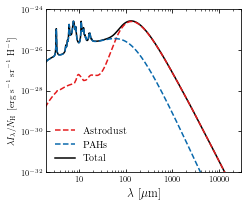

In [21]:
u_idx = np.argmin(np.abs(logU - 0.2)) # We could use interpolation here, 
                                      # but 0.2 is a provided value
    
fig, ax = plt.subplots(1,1,figsize=(3.5, 3.))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda\ [\mu{\rm m}]$', fontsize=12)
ax.set_ylabel(r'$\lambda I_\lambda/N_{\rm H}\ [{\rm erg}\ {\rm s}^{-1}\ {\rm sr}^{-1}\ {\rm H}^{-1}]$',
                 fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.axis([2., 3.e4,  1.e-32, 1.e-24])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(axis='both', which='both', labelsize=8,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')

ax.plot(wav.to(u.um), irem_mat_Ad[:,u_idx].to(u.erg/u.s), linestyle='--', color='#e41a1c', label=r'${\rm Astrodust}$')
ax.plot(wav.to(u.um), irem_mat_PAH[:,u_idx].to(u.erg/u.s), linestyle='--', color='#0868ac', label=r'${\rm PAHs}$')
ax.plot(wav.to(u.um), (irem_mat_Ad[:,u_idx]+irem_mat_PAH[:,u_idx]).to(u.erg/u.s), linestyle='-', color='k', label=r'${\rm Total}$', zorder=0)

ax.legend(loc='lower left', frameon=False, prop={'size': 10});

The same holds in polarization, though there is no PAH component.

In [22]:
cabspolBnu_Ad = hdul_ad[10].data*u.erg/u.s
ipol_mat_Ad = np.sum(cabspolBnu_Ad*f_Ad*dn_Ad, axis=2)

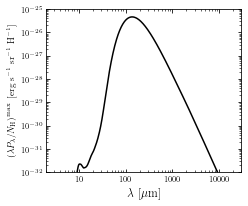

In [23]:
fig, ax = plt.subplots(1,1,figsize=(3.5, 3.))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda\ [\mu{\rm m}]$', fontsize=12)
ax.set_ylabel(r'$\left(\lambda P_\lambda/N_{\rm H}\right)^{\rm max}\ [{\rm erg}\ {\rm s}^{-1}\ {\rm sr}^{-1}\ {\rm H}^{-1}]$',
                 fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.axis([2., 3.e4,  1.e-32, 1.e-25])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.tick_params(axis='both', which='both', labelsize=8,
                 bottom=True, top=True, left=True, right=True,
                 direction='in')

ax.plot(wav.to(u.um), ipol_mat_Ad[:,u_idx].to(u.erg/u.s), linestyle='-', color='k');

The input size distributions (and $f_{\rm ion}$ and $f_{\rm align}$) can be changed as you like to produce different extinction curves and emission spectra, both total and polarized. 